In [3]:
import numpy as np
import pandas as pd 
import csv
import matplotlib.pyplot as plt
from matplotlib import*
from pandas import *
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import corner
from IPython.display import display, Math
import emcee

In [4]:
Data15=pd.DataFrame(np.loadtxt('SN_data_clean.txt', unpack = False))

SN_data_sim1= pd.read_csv('1SN_data_sim1.csv')
dm_prep=SN_data_sim1['mb1']-SN_data_sim1['m_th']
prep15=Data15[5]-Data15[1]
def dm_cut(df,start,end):
    return df.loc[start:end]

signal_15 = np.matrix(np.loadtxt('more_error_1500.txt', unpack = False))#1500x1500
dm15 = np.matrix(dm_cut(prep15,0,1499))
dmC1=np.matrix(dm_cut(prep15,0,20))
dmC2=np.matrix(dm_cut(prep15,0,149))
dmC3=np.matrix(dm_cut(prep15,0,628))

In [5]:
#size=1500
#I=np.matrix(np.identity(size))
#I.shape
def replaceDiag(matrix, replacementList):
    cp=matrix.copy()
    for i in range(len(replacementList)):
        cp[i,i] = 1/np.sqrt(replacementList[i,0])
    return cp

In [10]:
size=150
I=np.matrix(np.identity(size))
Q=np.matrix(np.loadtxt('n.txt', unpack = False))
N=replaceDiag(I,Q)
def lnlike(theta,dm,signal,size):
    sigma,A,M= theta
    #I=np.matrix(np.identity(size))
    s2=sigma**2
    C=A*signal+s2*N
    #T1=((A*signal)/s2)
    #T2=((A*signal)/s2)**2
    inv_C=np.linalg.inv(C)
    # print(N)
    detC=np.linalg.slogdet(C)
    Dm=dm+np.matrix(M*np.ones(size))
    #print(np.matmul(inv_C,np.transpose(Dm)).shape)
    #print(.5*np.matmul(np.transpose(Dm),np.matmul(inv_C,Dm)))
    return ((-.5*detC[1])-(.5*np.matmul(Dm,np.matmul(inv_C,np.transpose(Dm)))))[0,0]

In [11]:
# # def frange(start, stop, step):
#     i = start
#     while i < stop:
#         yield i
# i += step
data15=np.matrix(Data15)
j=0
zmax=0.107302
#print(data15.shape)
cutList=[]
while True:
    j=j+1
    if data15[j,0]>zmax/4:
        cutList.append(j)
        break
while True:
    j=j+1
    if data15[j,0]>zmax/2:
        cutList.append(j)
        break
while True:
    j=j+1
    if data15[j,0]>3*zmax/4:
        cutList.append(j)
        break
print(cutList)
        

[21, 150, 629]


In [12]:
SCut1=signal_15[:21,:21]
SCut2=signal_15[:150,:150]
SCut3=signal_15[:629,:629]

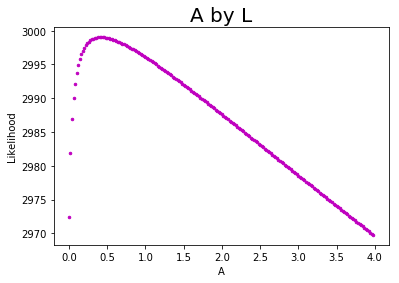

In [14]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

a=[]
for i in frange(0,4,.02):
    like=lnlike([.08,i,0],dmC2,SCut2,150)
    a.append(like)
A=np.arange(0,4,.02)
plt.plot(A,a,'m.',markersize=5)
plt.xlabel('A')
plt.ylabel('Likelihood')
plt.title('A by L', fontsize=20)
#plt.savefig('First 208Galaxy Location(b,l).png')
plt.show()

In [7]:
#test
# theta=[.08,.6,0]
# signal=signal_15
# size=1500
# v=lnlike(theta,dm15,signal,size)
# print(v)

In [16]:
def lnprior(theta):#Prior
    sigma,A,M= theta
    if .005 < sigma < 0.3 and 0< A < 5 and -1 < M < 1:
        return 0.0
    return -np.inf

def lnprob(theta,dm,signal,size):  #prob
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,dmC2,SCut2,size)

In [21]:
ndim, nwalkers = 3, 50
pos = [[.08,.6,0] + [1e-3]*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(dmC2,SCut2,150))

In [22]:
k=sampler.run_mcmc(pos,600)

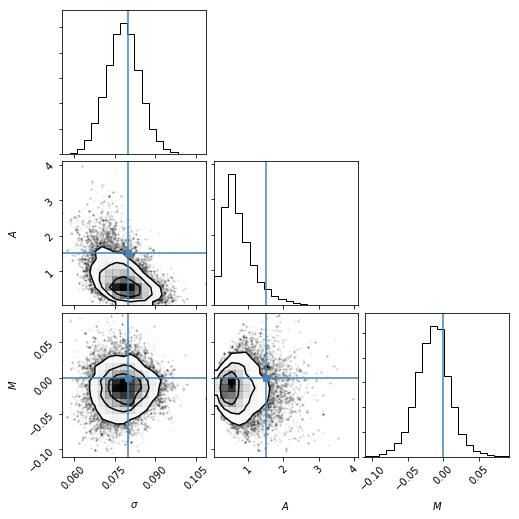

In [19]:
samples = sampler.chain[:, 10:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$\sigma$", "$A$", "$M$"],
                      truths=[.08, 1.5, 0])
plt.savefig('corner.png')

In [20]:
labels = ["\sigma", "A", "M"]

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.8f}}}^{{{2:.8f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

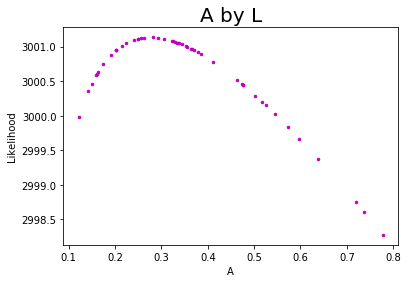

In [15]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step
A=k[0][:,1]
a=[]
for i in A:
    like=lnlike([.0808,i,-.0119],dm15,signal_15,1500)
    a.append(like)
plt.plot(A,a,'m.',markersize=5)
plt.xlabel('A')
plt.ylabel('Likelihood')
plt.title('A by L', fontsize=20)
#plt.savefig('First 208Galaxy Location(b,l).png')
plt.show()

In [18]:
z=np.poly1d(np.polyfit(A,a,4))
B=np.arange(0.1,0.8,.001)

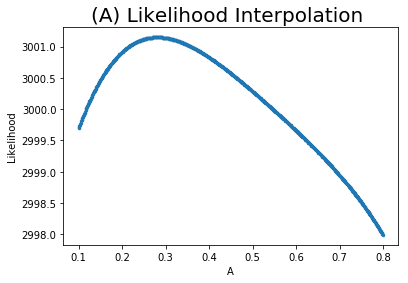

In [19]:
plt.plot(B,z(B),'.',markersize=5)
plt.xlabel('A')
plt.ylabel('Likelihood')
plt.title('(A) Likelihood Interpolation ', fontsize=20)
#plt.savefig('First 208Galaxy Location(b,l).png')
plt.show()

In [20]:
import scipy.integrate as integrate
Atot=integrate.quad(lambda x: z(x), 0,.8)
print(Atot[0]*.68)

1631.9517604261323


In [21]:
print(Atot[0])

2399.9290594501945


In [49]:
integrate.quad(lambda x: z(x), 0,.543931)

(1631.9513051739102, 1.8118299140711505e-11)

In [50]:
.543931-0.3583

0.18563100000000005

In [83]:
integrate.quad(lambda x: z(x), .0863785,.3583)

(815.9714166126319, 9.059102541593499e-12)

In [52]:
print(Atot[0]*.34)

815.9758802130661


In [84]:
.3583-.0863785

0.27192150000000004